In [1070]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")


excludedAttrsByDefault = ["STUDENT ID","GRADE","COURSE ID"]

data = pd.read_csv("./DATA.csv", sep=';')
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.drop(excludedAttrsByDefault)], data["GRADE"], test_size=0.2)

In [1071]:
from math import inf, log2

def isSuccess(Y):
    return (Y>=4) & (Y<=7) 

def getInfoT(T: np.array,Y:np.array):
    entrophy = 0.0

    succesFreq = len(Y[isSuccess(Y)])
    failedFreq = len(Y) - succesFreq

    if succesFreq==0 or failedFreq==0:
        return 0
    entrophy -= succesFreq/len(Y) * log2(succesFreq/len(Y))
    entrophy -= failedFreq/len(Y) * log2(failedFreq/len(Y))

    return entrophy
def getInfoTX(T:np.array,Y:np.array,attr:str):
    entrophy = 0.0
    signs = np.unique(T[attr])

    for sign in signs:
        Ti = T[T[attr] == sign]
        entrophy += len(Ti)/len(T) * getInfoT(Ti,Y[T[attr] == sign])

    return entrophy

def getSplitInfoX(T:np.array,Y:np.array,attr:str):
    entrophy = 0.0
    signs = np.unique(T[attr])

    for sign in signs:
        Ti = T[T[attr] == sign]
        entrophy -= len(Ti)/len(T) * log2(len(Ti)/len(T))

    return entrophy


def gainRatio(T:np.array,Y:np.array,attr:str):
    splitInfoX = getSplitInfoX(T,Y,attr)
    if abs(splitInfoX) < np.finfo(float).eps:
        return -inf

    return (getInfoT(T,Y) - getInfoTX(T,Y,attr)) / splitInfoX

def getAttrWithMaxGainRatio(T,Y,attrs:set[str]):
    maxGainRatio = -inf
    attrWithMaxGainRatio = None
    for index,attr in enumerate(list(attrs)):
        gr = gainRatio(T,Y,attr)
        if maxGainRatio < gr:
            maxGainRatio = gr
            attrWithMaxGainRatio = attr

    return attrWithMaxGainRatio

In [1072]:
from random import randint
attrsCount = int(len(data)**(1/2))
attrSet = set()
for i in range(attrsCount):
    attr = randint(1,30)
    if attr in attrSet:
        while attr in attrSet:
            attr = randint(1,30)
        
    attrSet.add(attr)

attrSet = set([str(attr) for attr in list(attrSet)])
print("Random chosen attribues are", attrSet)
# attrSet = set([str(attr) for attr in list(range(1,30))])

Random chosen attribues are {'25', '18', '8', '23', '6', '7', '22', '26', '11', '20', '12', '9'}


In [1073]:
class Node:
    children:dict[str,"Node"]
    parent:("Node" or None)
    attr:str
    value:any
    X:pd.Series
    Y:pd.Series
    def __init__(self,X=None,Y=None,parent=None,children=[],attr=None,value=None):
        self.children = dict().fromkeys(children)
        self.parent = parent
        self.attr = attr
        self.value = value
        self.X = X
        self.Y = Y


    def getattrs(self):
        attrs = set()
        if self.attr is not None:
            attrs.add(self.attr)
        node = self
        while node.parent is not None:
            node = node.parent
            if node.attr is not None:
                attrs.add(node.attr)

        return np.array(attrs)
            

In [1074]:
class ClassifierByTree:

    def __init__(self) -> None:
        self.root = Node(None,None,None,[],None,None)


    def learn(self,X,Y,attrSet):
        nodes = [self.root]
        self.root.X = X
        self.root.Y = Y

        i = 0
        while i < len(nodes):
            node = nodes[i]
            i += 1
            x = node.X
            y = node.Y
            if len(y)<2:
                continue
            
            attrs = attrSet - node.getattrs()
            resultAttr = getAttrWithMaxGainRatio(x,y,attrs)
            if resultAttr == None:
                continue
            node.attr = resultAttr

            values = np.unique(x[resultAttr])

            for index,value in enumerate(values):
                rowsWithValue = x[resultAttr]==value
                child = Node(x[rowsWithValue],y[rowsWithValue],node,[],None,value)
                nodes.append(child)
                node.children[value] = child

    def proba(self,sample):
        node = self.root
        while node.attr is not None:
            val = sample[node.attr]
            if val not in node.children.keys():
                break 
            node = node.children[val]
        X = node.X
        Y = node.Y
        return len(Y[isSuccess(Y)])/len(Y)

    def getRoot(self):
        return self.root

In [1075]:
clf = ClassifierByTree()
clf.learn(X_train,y_train,attrSet)

In [1076]:
TP, FP, TN, FN = 0, 0, 0, 0
x, y = [], []
TPR, FPR = [], []
accuracy, precision, recall = [], [], []
length = len(X_test)
# doorsteps = list(np.arange(0.0,1,0.1))
y_pred = y_test.copy()

TP, FP, TN, FN = 0, 0, 0, 0
for index in X_test.index:
    sample = X_test.T[index]
    originClass = y_test[index]
    pred = clf.proba(sample)
    if originClass >= 4 and pred >= 0.5:
        TP += 1
    if originClass >= 4 and pred < 0.5:
         FN += 1
    if originClass <= 3 and pred < 0.5:
        TN += 1
    if originClass <= 3 and pred >= 0.5:
        FP += 1
    y_pred[index] = pred


print(f'count of samples {length}\n\tT\tF\nP\t{TP}\t{FP}\nN\t{TN}\t{FN}')
accuracy = (TP+TN)/(TP+FP+TN+FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
print(f'accuracy is {accuracy}\nprecision is {precision}\nrecall is {recall}')


count of samples 29
	T	F
P	5	9
N	10	5
accuracy is 0.5172413793103449
precision is 0.35714285714285715
recall is 0.5


In [1077]:
result = []
for index in y_pred.index:
    result.append((index,y_test[index]>=4,y_pred[index]))
result.sort(key=lambda x:x[2],reverse=True)
for i in result:
    print(i)


(82, True, 1.0)
(60, False, 1.0)
(16, False, 1.0)
(6, True, 1.0)
(140, True, 1.0)
(144, False, 1.0)
(26, False, 1.0)
(99, True, 1.0)
(92, True, 1.0)
(124, False, 1.0)
(67, False, 0.8571428571428571)
(39, False, 0.6666666666666666)
(11, False, 0.5555555555555556)
(22, False, 0.5)
(45, False, 0.3111111111111111)
(118, False, 0.25)
(112, False, 0.0)
(105, True, 0.0)
(122, False, 0.0)
(9, False, 0.0)
(71, True, 0.0)
(58, False, 0.0)
(48, False, 0.0)
(120, False, 0.0)
(125, False, 0.0)
(4, False, 0.0)
(90, True, 0.0)
(77, True, 0.0)
(43, True, 0.0)


[5, 5]
[1, 0]
[1, 0]
[1, 0]
[7, 5]
[0, 0.2631578947368421, 0.3157894736842105, 0.3684210526315789, 0.42105263157894735, 0.7894736842105263, 1] [0, 0.5, 0.5, 0.5, 0.5, 1.0, 1]


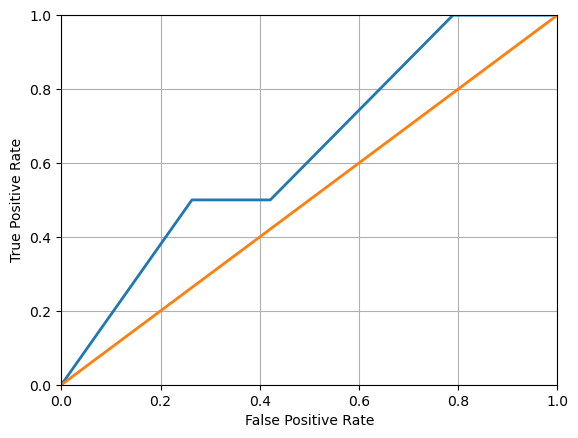

In [1078]:
import matplotlib.pyplot  as plt
PRED = 2
ORIG = 1

fig, ax = plt.subplots()
rocX = [0]
rocY = [0]
stepX = 1/(sum([0 if i[ORIG] else 1 for i in result]))
stepY = 1/(sum([1 if i[ORIG] else 0 for i in result]))
left,right = 0,0
while right < len(result):
    classPredCount = [0,0]
    while right < len(result) and result[right][PRED] == result[left][PRED]:
        if result[right][ORIG]:
            classPredCount[1] += 1
        else:
            classPredCount[0] += 1
        right += 1
    rocY.append(rocY[-1]+stepY*classPredCount[1])
    rocX.append(rocX[-1]+stepX*classPredCount[0])


    left = right + 1
    right = left
    print(classPredCount)
rocY.append(1)
rocX.append(1)

print(rocX,rocY)
ax.plot(rocX,rocY, linewidth=2.0)
ax.plot(np.linspace(0,1,10),np.linspace(0,1,10), linewidth=2.0)
ax.grid()

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
